# Optimizing Stiffness Constants

Suppose we have $n$ blocks, each of width $w$, at positions $x\in\mathbb{R}^n$.
The blocks are positioned between two walls at $0$ and $l$.
The leftmost block is connected to the left wall via a spring with stiffness coefficient $k_1$,
the rightmost block is connected to the right wall via a spring with stiffness coefficient $k_{n+1}$,
and the $i$th block is connected to the $(i+1)$th block via a spring with stiffness coefficient $k_{i+1}$.
The equilibrium position of all the blocks can be found by solving the optimization problem
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \frac{1}{2}k_1x_1^2 + \frac{1}{2}k_2(x_2-x_1)^2 + \ldots + \frac{1}{2}k_{n+1}(l-x_n)^2\\[.2cm]
\mbox{subject to} & x_1 \geq w/2, \quad x_n \leq l - w/2, \\
& x_i - x_{i-1} \geq w, \quad i=2,\ldots,n-1,
\end{array}
\label{eq:prob}
\end{equation}
with variable $x$ and solution denoted $x^\star$.
The objective is the potential energy of the system, and the constraints express
the fact that the blocks have a width, and cannot penetrate each other or the walls.

In [1]:
# NOTE: this notebook requires ffmpeg, which can be installed on ubuntu with "sudo apt install ffmpeg"
# and on mac with "brew install ffmpeg"
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cvxpylayers.tensorflow import CvxpyLayer
import matplotlib.patches as patches
from matplotlib import animation, rc
rc('animation', html='html5')

We can easily set up this problem as a CVXPY problem, with parameter $k$ and variable $x$:

In [2]:
n = 5
l = 1
w = .05

k = cp.Parameter(n + 1, nonneg=True)
x = cp.Variable(n + 2)
objective = cp.sum(cp.multiply(k, .5 * cp.square(cp.diff(x))))
constraints = [x[0] == 0, x[-1] == l] + [x[i] - x[i-1] >= w for i in range(1, n+2)]
prob = cp.Problem(cp.Minimize(objective), constraints)

We can easily convert this problem to a `tensorflow` `CvxpyLayer` in one line.
The layer maps stiffness coefficients to block positions, or $x^\star(k)$.

In [3]:
prob_tf = CvxpyLayer(prob, [k], [x])

Our goal is to tune the stiffness coefficients such that the block positions are close to target positions,
or solve the problem
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \|x^\star(k) - x^\mathrm{targ}\|_2^2,
\end{array}
\end{equation}
with variable $k\in\mathbb{R}^{n+1}$.

In [4]:
tf.random.set_seed(1)
k = tf.constant(tf.ones([n + 1], dtype=tf.float64))
x_targ = tf.sort(tf.random.uniform([n], dtype=tf.float64))
x_targ

<tf.Tensor: id=21, shape=(5,), dtype=float64, numpy=array([0.04779355, 0.28081525, 0.32104743, 0.33551271, 0.80628428])>

We can (approximately) solve this problem via gradient descent:

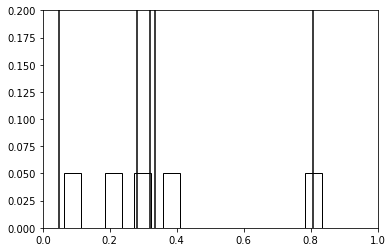

In [5]:
x, = prob_tf(k)
x_np = x.numpy()

fig, ax = plt.subplots()
ax.set_xlim((0, 1))
ax.set_ylim((0, w*4))
rects = []
for i in range(n):
    plt.axvline(x_targ[i].numpy(), c='k')
    rect = patches.Rectangle((x_np[i + 1] - w/2, 0), w, w, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    rects.append(rect)

def animate(i):
    global k
    with tf.GradientTape() as tape:
        tape.watch(k)
        x, = prob_tf(k)
        loss = tf.reduce_sum((x[1:-1] - x_targ)**2)
    grad, = tape.gradient(loss, [k])
    k = k - .1 * grad
    k = tf.maximum(k, 0.0)
    for i in range(n):
        rects[i].xy = (x.numpy()[i + 1] - w/2, 0)
    return rects

anim = animation.FuncAnimation(fig, animate,
                               frames=300, interval=50, blit=True)
anim